# Object Detection

One way to apply deep learning to object detection is to use region-based CNNs also known as R-CNNs. The first R-CNN comprised of three stages. The first stage scans the image and identifies up to 2.000 bounding boxes representing regions of interest or regions that might contain objects. The second stage is a deep CNN that extracts features from regions of interest and the third is a support vector machine that classifies the features. The output is a collection of bounding boxes with class labels and confidence scores. An algorithm called non-maximum supression (NMS) filters the output and selects the best bounding box for each object.

A detector emits everal bounding boxes for each objet, if a photo contains on instance of agiven class NMS selects the bounding box with the highest confidence score. I the photo contains two objects of the same class NMS divides the bounding boxes ito groups and selects the box with the hightest confidence score in each group. It groups the boxes based on the amout of overlap between them. Overlap is computed by dividing the area of intersection between two boxes by the area formed by the union of the boxes. If the resulting intersection-over-union (IoU) score is greater than the predetermined threshold typicaly 0.5 NMS assigns the boxes to the same group, otherwise it assigns them to separate groups. If two obbjects of the same class have little or no overlap NMS easily separates the two but if two instances of the same class overlap significanly the IoU threshold might have to be adjuxted to achieve separation.

The first stage of most R-CNN implementations uses an algorithm called selective search to identify regions of interest by keying on similarities in color, texture, shape, and size. Even with selective search narrowing the list of candidate regions input to stage 2 an R-CNN can't do object detection in real time because the CNN individually processes the 2.000 or so regions of interests identified in stage 1. 

A paper titled "Fast R-CNN" adresses this by proposing a modified architecture in which the entire image passes through the CNN one time. Selective search or another similar algorithm identifies regions of interest and those regions are projected onto the feature map generated by the CNN. A region of interest (ROI) pooling layer then uses a form of max pooling to reduce the features in each region of interest to a fixed-length vector independent of the region's size and shape. Classification of the feature vector is performed by fully connected layers rather than SVMs and the output is split to include both a softmax classifier and a bounding-box regressor.

A paper titled "Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks" further boosed performance by replacing selective search with a region proposal network or RPN which is a shallow cNN that shares layers with the main CNN. To generate region proposals, it slides a window over the feature map generated by the last shared layer, at each stop in the window's travel the RPN evaluates n candidate regions called anchors or anchor boxes and computes an objectness score for each based on IoU scores with ground-truth boxes. Objectness scores and anchor boxes are input to fully connected layers for classification and regression. The output from these layers ultimately determines the regions of interest projected onto the feature map generated by the main CNN and forwarded to the ROI pooling layer.

Mask R-CNNs introduced in the paper "Mask R-CNN" extend Faster R-CNN by adding instance segmentation, which identifies the shapes of objects detected in an image using segmentation masks. Impact on performance is minimal with the benefit of providing more detail about the objects detected. They also replace ROI pooling with ROI alignment which discards less information when generating feature vectors whose boundaries don't perfectlly align with the boundaries of the regions they represent.

MaskRCNN-12-int8.onnx is a downloadable file developed by Facebook Research containing a sophisticated Mask R-CNN. It uses a ResNet50 backbone to extract features from the images input to it and it includes a branch that computes instance segmentation masks in parallel with bounding box computations, it was trained on the COCO dataset.

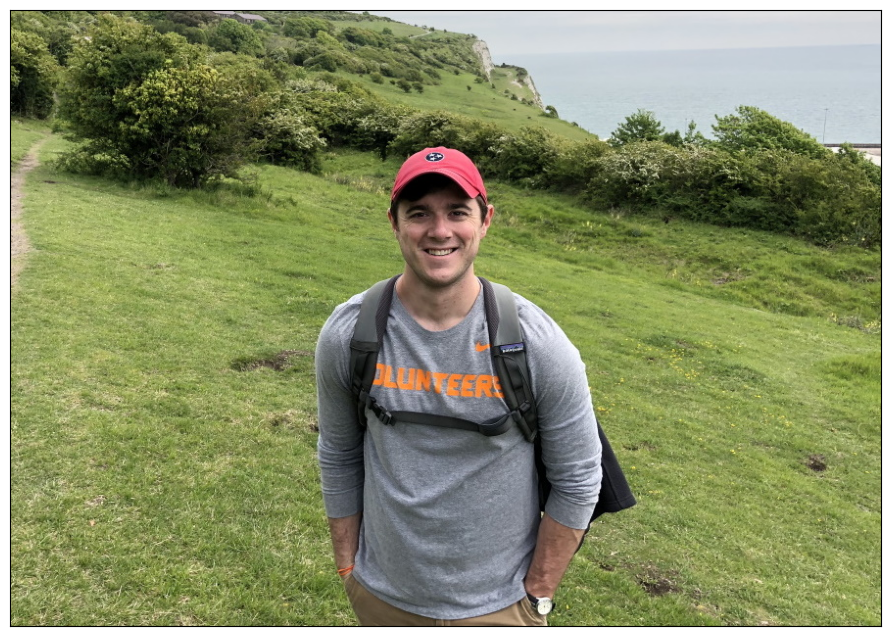

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

image = Image.open('Data/adam.jpg')
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

In [2]:
from mask import *
import onnxruntime as rt

image_data = preprocess(image)
session = rt.InferenceSession('MaskRCNN-12-int8.onnx')
input_name = session.get_inputs()[0].name
result = session.run(None, {input_name:image_data})

In [3]:
result

[array([[ 377.50537,  174.36874,  801.177  ,  787.7125 ],
        [ 428.15994,  344.70105,  699.99097,  599.8499 ],
        [ 757.1859 ,  529.4938 ,  814.2776 ,  658.8041 ],
        [ 432.57123,  351.229  ,  672.2242 ,  484.63702],
        [ 435.53653,  357.34235,  494.73557,  516.4939 ],
        [ 672.56714,  516.2991 ,  822.82153,  663.68726],
        [ 608.1904 ,  361.0429 ,  686.1207 ,  552.70105],
        [ 629.84894,  355.3375 ,  799.4963 ,  718.9458 ],
        [ 437.99078,  331.19318,  709.4969 ,  748.2785 ],
        [ 438.44028,  348.14404,  579.8056 ,  546.0588 ],
        [1152.0518 ,  203.89978, 1163.7583 ,  223.2485 ],
        [1151.8087 ,  132.45256, 1164.0013 ,  150.6876 ],
        [1151.8087 ,  404.0875 , 1164.0013 ,  423.058  ],
        [ 416.03802,  396.8123 ,  694.8975 ,  511.93896],
        [ 683.35236,  765.0078 ,  701.3403 ,  784.47546]], dtype=float32),
 array([ 1, 25, 27, 25, 25, 27, 25, 27, 27, 25,  1,  1,  1, 25, 75],
       dtype=int64),
 array([0.99911565, 0.8

Array of 4 arrays:
1. first array contains the bounding boxes of the detected objects
2. second array is an array of integer class identifiers corresponding to classes in the COCO dataset
3. confidence scores for all objects detected
4. contains segmentation masks for each object, each mask is a 28x28 array of floating-point values sometimes referred to as soft masks

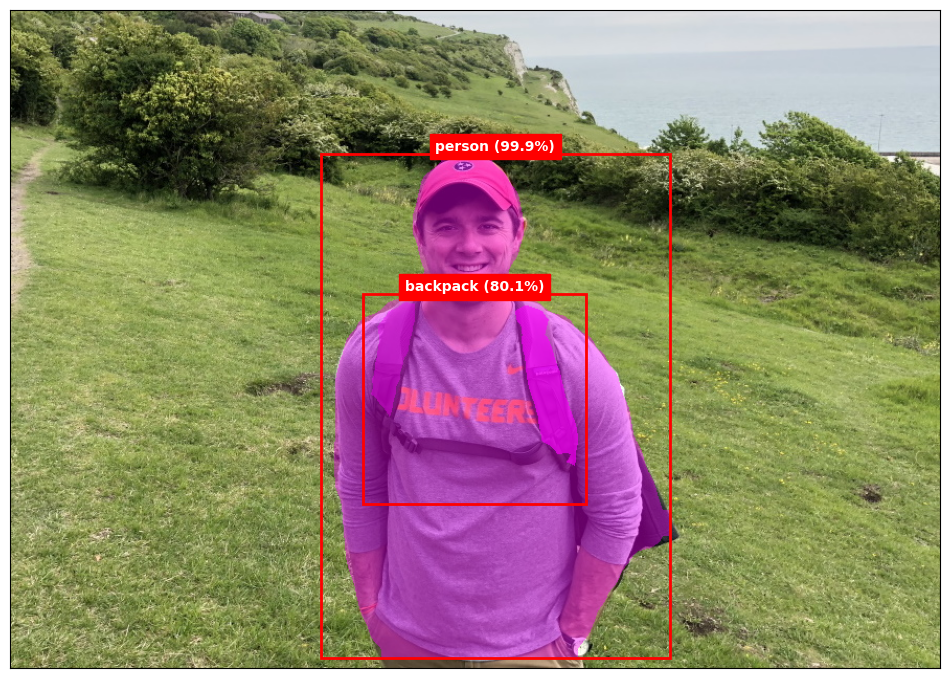

In [4]:
boxes = result[0]
labels = result[1]
scores = result[2]
masks = result[3]

annotate_image(image, boxes, labels, scores, masks)

By default annotate_image ignores objects identified with less than 70% confidence

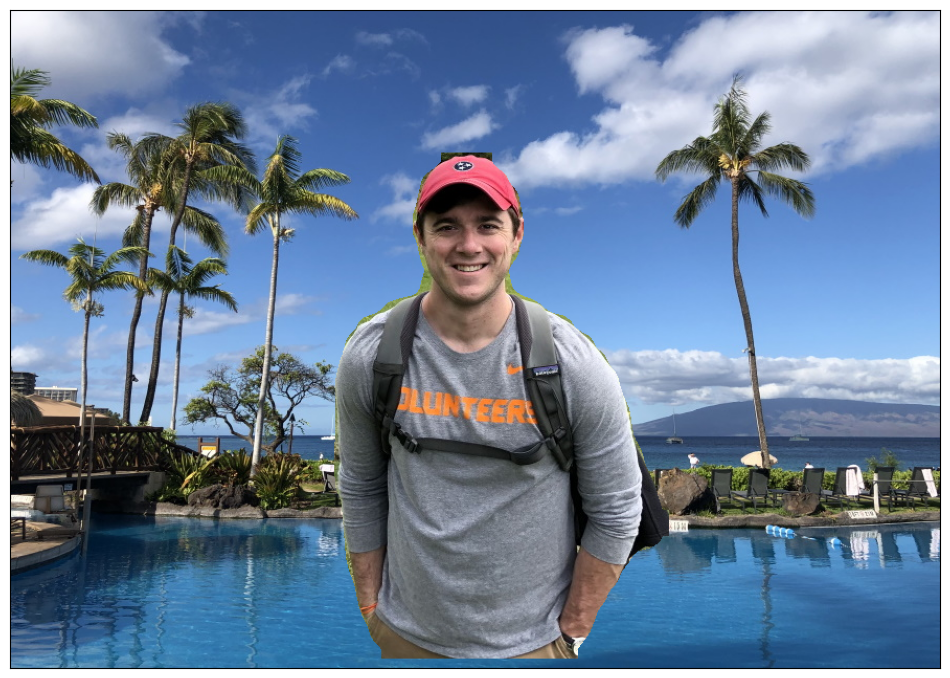

In [6]:
fg_image = Image.open('Data/adam.jpg')
bg_image = Image.open('Data/maui.jpg')

change_background(session, fg_image, bg_image)

## YOLO

YOLO is introduced in a paper titled "You Only Look Once: Unified, Real-Time Object Detection" and it proposes an alternative to R-CNN. YOLO works by dividing feature maps into grids of cells and evaluating each cell for the presence of an object. Using the anchor-box concept borrowed from Faster R-CNN YOLO analyzes bounding boxes of various shapes and sizes around each cell and assigns classes and probabilities to the boxes. One CNN handles everything including feature extraction, classification and regression designating the sizes and locations of the bounding boxes.

In [2]:
from yolov3 import *

model = make_yolov3_model()
weight_reader = WeightReader('yolov3.weights')
weight_reader.load_weights(model)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_0 (Conv2D)     │ (None, None,      │        864 │ input_layer_1[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bnorm_0             │ (None, None,      │        128 │ conv_0[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_0 (LeakyReLU) │ (None, None,      │          0 │ bnorm_0[0][0]     │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, None,      │          0 │ leaky_0[0][0]     │
│ (ZeroPadding2D)     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, None,      │     18,432 │ zero_padding2d_5… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bnorm_1             │ (None, None,      │        256 │ conv_1[0][0]      │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_1 (LeakyReLU) │ (None, None,      │          0 │ bnorm_1[0][0]     │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, None,      │      2,048 │ leaky_1[0][0]     │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bnorm_2             │ (None, None,      │        128 │ conv_2[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_2 (LeakyReLU) │ (None, None,      │          0 │ bnorm_2[0][0]     │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, None,      │     18,432 │ leaky_2[0][0]     │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bnorm_3             │ (None, None,      │        256 │ conv_3[0][0]      │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_3 (LeakyReLU) │ (None, None,      │          0 │ bnorm_3[0][0]     │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_23 (Add)        │ (None, None,      │          0 │ leaky_1[0][0],    │
│                     │ None, 64)         │            │ leaky_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_6    │ (None, None,      │          0 │ add_23[0][0]      │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_5 (Conv2D)     │ (None, None,      │     73,728 │ zero_padding2d_6

 Total params: 62,001,757 (236.52 MB)

 Trainable params: 61,949,149 (236.32 MB)

 Non-trainable params: 52,608 (205.50 KB)

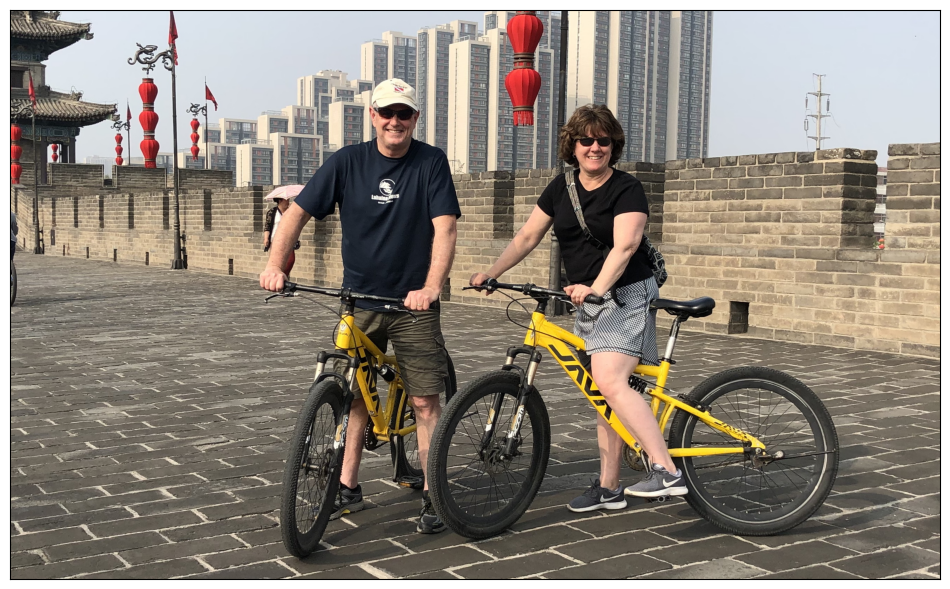

In [3]:
image = plt.imread('Data/xian.jpg')
width, height = image.shape[1], image.shape[0]
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(image)

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

x = load_img('Data/xian.jpg', target_size=(YOLO3.width, YOLO3.height))
x = img_to_array(x) / 255
x = np.expand_dims(x, axis=0)
y = model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [5]:
y

[array([[[[-8.98425430e-02,  5.36360264e-01,  3.98187786e-01, ...,
           -4.67695475e+00, -5.17794228e+00, -5.12420034e+00],
          [ 4.01227415e-01,  7.30358481e-01,  2.24357575e-01, ...,
           -5.48743010e+00, -5.48529816e+00, -5.37987041e+00],
          [-1.25483796e-01,  5.29332757e-01,  5.91184378e-01, ...,
           -5.43800831e+00, -5.36464119e+00, -5.13323498e+00],
          ...,
          [ 5.01890182e-01,  1.11665583e+00,  2.07815289e-01, ...,
           -4.53113604e+00, -5.19466734e+00, -4.90647888e+00],
          [-5.52606940e-01,  1.41273963e+00,  2.34109998e-01, ...,
           -3.26218414e+00, -4.56168270e+00, -4.14116335e+00],
          [ 1.14036798e-02,  6.17332578e-01,  5.01301169e-01, ...,
           -2.78488469e+00, -4.20335150e+00, -3.29798198e+00]],
 
         [[ 5.29984534e-02,  5.64586043e-01, -1.58685505e-01, ...,
           -4.93629265e+00, -4.95511818e+00, -5.27100754e+00],
          [ 4.45903480e-01,  7.83440471e-01, -1.27583027e-01, ...,
     

In [6]:
boxes = decode_predictions(y, width, height)

for box in boxes:
    print(f'({box.xmin}, {box.ymin}), ({box.xmax}, {box.ymax}), ' + f'{box.label}, {box.score}')

(692, 232), (1303, 1490), person, 0.9970048069953918
(1314, 327), (1920, 1496), person, 0.9957388639450073
(716, 786), (1277, 1634), bicycle, 0.9924144744873047
(1210, 845), (2397, 1600), bicycle, 0.9957170486450195


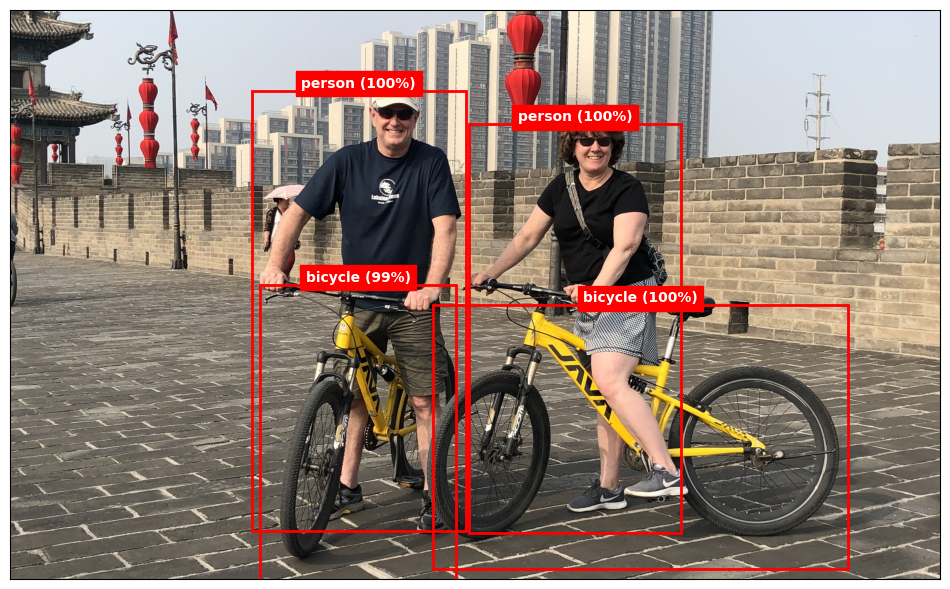

In [7]:
annotate_image('Data/xian.jpg', boxes)